In [1]:
from examples.tvb_nest.notebooks.cerebellum.scripts import *

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/utils/data_structures_utils.py:718: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (transpose is "horizontal" or "row" and shape[0] > shape[1]) or \
/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/utils/data_structures_utils.py:719: SyntaxWarning: "is" with a literal. Did you mean "=="?
  (transpose is "vertical" or "column" and shape[0] < shape[1]):


2022-05-24 08:59:12,188 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-05-24 08:59:12,188 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-05-24 08:59:12,200 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-05-24 08:59:12,200 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-05-24 08:59:12,202 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2022-05-24 08:59:12,202 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2022-05-24 08:59:12,206 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2022-05-24 08:59:12,206 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2022-05-24 08:59:12,208 - INFO - tvb_multiscale.tv

<Figure size 432x288 with 0 Axes>

params =
 OrderedDict([('STIMULUS', 5.0), ('I_E', 0.25), ('I_S', -0.25), ('W_IE', 0.25), ('W_RS', -3.0), ('TAU_E', -2.0), ('TAU_I', 11.11111111111111), ('TAU_S', 11.11111111111111), ('TAU_R', 40.0)])


Fitting for G = 2.5!


Fitting run 0 

normalized weights [min, max] = 
 [1.0, 30.975860931479346]

normalized weights [min, max] = 
 [1.0, 30.975860931479346]


/home/docker/packages/tvb-multiscale/tvb_multiscale/core/spiking_models/node_set.py:34: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def __init__(self, nodes=pd.Series(), **kwargs):
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/spiking_models/devices.py:953: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def __init__(self, device_set=pd.Series(), **kwargs):


Effective FIC = FIC * G * indegree / mean_indegree = 0.2 * 0.0160256 * indegree / 108.485 = 2.95444e-05 * indegree
2022-05-24 08:59:14,943 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: cd8805e0-f88e-4d40-b7d5-569751964e38'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: 1e39bf8d-ff40-4ef7-b32e-10811dd63fd2
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ................. True
  exclusive ................ False
  voi ...................... --------------------
  proxy_inds ............... -------

Running 3 simulations in 3 batches.:   0%|          | 0/3 [00:00<?, ?it/s]

2022-05-24 08:59:54,778 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-05-24 08:59:54,779 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-05-24 08:59:54,778 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-05-24 08:59:54,780 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-05-24 08:59:54,779 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-05-24 08:59:54,781 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-05-24 08:59:54,780 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-05-24 08:59:54,782 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2022-05-24 08:59:54,782 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2022-05

/home/docker/packages/tvb-multiscale/tvb_multiscale/core/spiking_models/node_set.py:34: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def __init__(self, nodes=pd.Series(), **kwargs):
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/spiking_models/node_set.py:34: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def __init__(self, nodes=pd.Series(), **kwargs):
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/spiking_models/node_set.py:34: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def __init__(self, nodes=pd.Series(), **kwargs):
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/spiking_models/devices.py:953: FutureWarnin


normalized weights [min, max] = 
 [1.0, 30.975860931479346]
Effective FIC = FIC * G * indegree / mean_indegree = 0.2 * 0.0160256 * indegree / 108.485 = 2.95444e-05 * indegree
2022-05-24 08:59:59,199 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!

normalized weights [min, max] = 
 [1.0, 30.975860931479346]
Effective FIC = FIC * G * indegree / mean_indegree = 0.2 * 0.0160256 * indegree / 108.485 = 2.95444e-05 * indegree
2022-05-24 08:59:59,210 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!

normalized weights [min, max] = 
 [1.0, 30.975860931479346]
Effective FIC = FIC * G * indegree / mean_indegree = 0.2 * 0.0160256 * indegree / 108.485 = 2.95444e-05 * indegree
2022-05-24 08:59:59,235 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - C

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]


Fitting run 1 

normalized weights [min, max] = 
 [1.0, 30.975860931479346]

normalized weights [min, max] = 
 [1.0, 30.975860931479346]
Effective FIC = FIC * G * indegree / mean_indegree = 0.2 * 0.0160256 * indegree / 108.485 = 2.95444e-05 * indegree
2022-05-24 09:00:55,178 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: 11c0027c-ccc8-497d-9293-541912699ee7'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: 2745a235-263e-4969-aae7-abc31e36ac29
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ......

Running 3 simulations in 3 batches.:   0%|          | 0/3 [00:00<?, ?it/s]

Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: 7c097e82-8b19-4610-bd35-e1e357601e98'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: b21dc925-cff9-499c-baae-faaf14fe5a9e
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ................. True
  exclusive ................ False
  voi ...................... --------------------
  proxy_inds ............... --------------------
  synchronization_time ..... 0.0
  connectivity ............. Connectivity gid: 20e3ca37-d302-43ac-9361-ceace26d6dcf
  conduction_speed ......... 3.0
  coupling ................. SigmoidalPreThalamoCortical gid: dd4008ae-df05-4ad5-9906-ab49dcc2f342
  surface .................. None
  stimu

/home/docker/packages/tvb-multiscale/tvb_multiscale/core/spiking_models/node_set.py:34: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def __init__(self, nodes=pd.Series(), **kwargs):
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/spiking_models/node_set.py:34: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def __init__(self, nodes=pd.Series(), **kwargs):
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/spiking_models/devices.py:953: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def __init__(self, device_set=pd.Series(), **kwargs):
/home/docker/packages/tvb-multiscale/tvb_multiscale/core/spiking_models/devices.py:953: FutureW


normalized weights [min, max] = 
 [1.0, 30.975860931479346]
Effective FIC = FIC * G * indegree / mean_indegree = 0.2 * 0.0160256 * indegree / 108.485 = 2.95444e-05 * indegree
2022-05-24 09:01:45,540 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!

normalized weights [min, max] = 
 [1.0, 30.975860931479346]
Effective FIC = FIC * G * indegree / mean_indegree = 0.2 * 0.0160256 * indegree / 108.485 = 2.95444e-05 * indegree
2022-05-24 09:01:45,560 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
 Neural network successfully converged after 56 epochs.
Sampling posterior...


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]


Fitting run 2 

normalized weights [min, max] = 
 [1.0, 30.975860931479346]

normalized weights [min, max] = 
 [1.0, 30.975860931479346]
Effective FIC = FIC * G * indegree / mean_indegree = 0.2 * 0.0160256 * indegree / 108.485 = 2.95444e-05 * indegree
2022-05-24 09:02:50,390 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: 11ed13bc-b9a8-4f33-8747-a22e56bf40f9'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: e633b19e-0e41-44c5-b600-b8d1ba119229
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ......

Running 3 simulations in 3 batches.:   0%|          | 0/3 [00:00<?, ?it/s]

Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: 577f1db8-162b-4be5-9852-67a0ea3a5351'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: 2990d5a0-ae8d-4c75-af70-d1d492209d47
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ................. True
  exclusive ................ False
  voi ...................... --------------------
  proxy_inds ............... --------------------
  synchronization_time ..... 0.0
  connectivity ............. Connectivity gid: eb3833af-5101-4359-ab4c-23c1a54e748f
  conduction_speed ......... 3.0
  coupling ................. SigmoidalPreThalamoCortical gid: cd3da92e-1049-4ad7-b8af-953b9b5a2988
  surface .................. None
  stimu

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]


Fitting run 3 

normalized weights [min, max] = 
 [1.0, 30.975860931479346]

normalized weights [min, max] = 
 [1.0, 30.975860931479346]
Effective FIC = FIC * G * indegree / mean_indegree = 0.2 * 0.0160256 * indegree / 108.485 = 2.95444e-05 * indegree
2022-05-24 09:05:12,591 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: 385afa56-15d4-4bdd-9572-554a8eff52af'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: 33e887db-c582-4310-ac4f-73774b03f801
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ......

Running 3 simulations in 3 batches.:   0%|          | 0/3 [00:00<?, ?it/s]

Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: 4d99fa65-2d44-4c2c-9776-ed5aa83b3f90'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: 4f732154-f8b7-42f7-851f-919bb919e3b6
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ................. True
  exclusive ................ False
  voi ...................... --------------------
  proxy_inds ............... --------------------
  synchronization_time ..... 0.0
  connectivity ............. Connectivity gid: 23f93a82-475c-4885-848e-971f7cd59f4d
  conduction_speed ......... 3.0
  coupling ................. SigmoidalPreThalamoCortical gid: 41d18469-e9e4-4ece-8e89-8edba69c8b61
  surface .................. None
  stimu

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]


Fitting run 4 

normalized weights [min, max] = 
 [1.0, 30.975860931479346]

normalized weights [min, max] = 
 [1.0, 30.975860931479346]
Effective FIC = FIC * G * indegree / mean_indegree = 0.2 * 0.0160256 * indegree / 108.485 = 2.95444e-05 * indegree
2022-05-24 09:07:27,370 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: 1ba06f10-033f-4090-a83d-a76b992d27f6'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: 4e0cdc94-0797-4f5e-8ca9-0cacbb3d56da
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ......

Running 3 simulations in 3 batches.:   0%|          | 0/3 [00:00<?, ?it/s]

Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: a9568881-d778-4ba4-a87a-23a2295b33ca'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: 8a794065-6817-4381-afe9-d51f3accd11f
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ................. True
  exclusive ................ False
  voi ...................... --------------------
  proxy_inds ............... --------------------
  synchronization_time ..... 0.0
  connectivity ............. Connectivity gid: 1d3f9b8c-a517-4eff-9093-8a517be52e5f
  conduction_speed ......... 3.0
  coupling ................. SigmoidalPreThalamoCortical gid: a5b11eca-7444-4eae-9f6e-6cce117bbbda
  surface .................. None
  stimu

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]


Fitting run 5 

normalized weights [min, max] = 
 [1.0, 30.975860931479346]

normalized weights [min, max] = 
 [1.0, 30.975860931479346]
Effective FIC = FIC * G * indegree / mean_indegree = 0.2 * 0.0160256 * indegree / 108.485 = 2.95444e-05 * indegree
2022-05-24 09:09:30,653 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: 4705f286-faaf-4f9f-b404-6a4984089488'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: 46fea5b8-b698-493c-a499-d8c5a6f42e6e
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ......

Running 3 simulations in 3 batches.:   0%|          | 0/3 [00:00<?, ?it/s]

Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: 30adde96-efc6-4061-8d6a-4f9d4d794eee'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: a654b021-2c09-4219-911e-51b8d0b2dccd
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ................. True
  exclusive ................ False
  voi ...................... --------------------
  proxy_inds ............... --------------------
  synchronization_time ..... 0.0
  connectivity ............. Connectivity gid: 2619324b-4128-499e-9d6e-ac845842ac2f
  conduction_speed ......... 3.0
  coupling ................. SigmoidalPreThalamoCortical gid: c4c0f67c-e7c4-4a12-a0c8-827f0140c8eb
  surface .................. None
  stimu

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]


Fitting run 6 

normalized weights [min, max] = 
 [1.0, 30.975860931479346]

normalized weights [min, max] = 
 [1.0, 30.975860931479346]
Effective FIC = FIC * G * indegree / mean_indegree = 0.2 * 0.0160256 * indegree / 108.485 = 2.95444e-05 * indegree
2022-05-24 09:11:35,536 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!


/home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/cerebellum/scripts.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: fc281be9-d14a-4e11-b89d-ce1231ef2325'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: c0cf7333-d02e-49a4-98c4-4253ed1f1c99
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ................. True
  exclusive ................ False
  voi ...................... --------------------
  proxy_inds ............... --------------------
  synchronization_time ..... 0.0
  connectivity ............. Connectivity gid: cb0cb941-bb39-4ca3-8abb-d5f8cdc3ed77
  conduction_speed ......... 3.0
  coupling ................. SigmoidalPreThalamoCortical gid: f430aa4b-b89a-4b5d-a670-9a2bc025f65e
  surface .................. None
  stimu

Running 3 simulations in 3 batches.:   0%|          | 0/3 [00:00<?, ?it/s]

/home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/cerebellum/scripts.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: 3a79b0c3-4b4e-456b-995d-1f7edd948cd4'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: 4ccc0fee-64b5-44ed-beb8-b72fdccfdaf4
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ................. True
  exclusive ................ False
  voi ...................... --------------------
  proxy_inds ............... --------------------
  synchronization_time ..... 0.0
  connectivity ............. Connectivity gid: d2461e21-d547-49d7-aaa2-8df3f96081a0
  conduction_speed ......... 3.0
  coupling ................. SigmoidalPreThalamoCortical gid: 265abc60-b89f-47dd-9317-c7bc676a805d
  surface .................. None
  stimu

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]


Fitting run 7 

normalized weights [min, max] = 
 [1.0, 30.975860931479346]

normalized weights [min, max] = 
 [1.0, 30.975860931479346]
Effective FIC = FIC * G * indegree / mean_indegree = 0.2 * 0.0160256 * indegree / 108.485 = 2.95444e-05 * indegree
2022-05-24 09:13:36,679 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: 156d52e0-d356-4066-8a58-2a5477f7d9dd'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: b2377bd0-e319-4815-9f6f-42256be9ee0f
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ......

Running 3 simulations in 3 batches.:   0%|          | 0/3 [00:00<?, ?it/s]

Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: dd78489b-45b5-4a78-99bd-2d05a13159e6'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: f7188b3a-29e2-4fb3-aacc-f445928eb415
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ................. True
  exclusive ................ False
  voi ...................... --------------------
  proxy_inds ............... --------------------
  synchronization_time ..... 0.0
  connectivity ............. Connectivity gid: cd347848-f5e2-4620-bf4b-aced7a306be5
  conduction_speed ......... 3.0
  coupling ................. SigmoidalPreThalamoCortical gid: 4dcc4122-99e5-4b6c-85a0-18896e6fde82
  surface .................. None
  stimu

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]


Fitting run 8 

normalized weights [min, max] = 
 [1.0, 30.975860931479346]

normalized weights [min, max] = 
 [1.0, 30.975860931479346]
Effective FIC = FIC * G * indegree / mean_indegree = 0.2 * 0.0160256 * indegree / 108.485 = 2.95444e-05 * indegree
2022-05-24 09:15:37,860 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: f3e5a390-af38-4ddb-8cd2-29637344675d'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: bc23bef1-b126-401c-ac73-194dc44c9b54
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ......

Running 3 simulations in 3 batches.:   0%|          | 0/3 [00:00<?, ?it/s]

Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: 733fbec1-bf99-4c5d-993a-c5cba7bede3a'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: b8f7c9bb-e369-4aa8-969f-03bc090b8121
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ................. True
  exclusive ................ False
  voi ...................... --------------------
  proxy_inds ............... --------------------
  synchronization_time ..... 0.0
  connectivity ............. Connectivity gid: 1c650222-2e2c-428c-a84d-74b75bf0aeec
  conduction_speed ......... 3.0
  coupling ................. SigmoidalPreThalamoCortical gid: 0c03b637-3af6-4c06-a99e-a12dd0ae4d0f
  surface .................. None
  stimu

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]


Fitting run 9 

normalized weights [min, max] = 
 [1.0, 30.975860931479346]

normalized weights [min, max] = 
 [1.0, 30.975860931479346]
Effective FIC = FIC * G * indegree / mean_indegree = 0.2 * 0.0160256 * indegree / 108.485 = 2.95444e-05 * indegree
2022-05-24 09:17:35,614 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: d4ee6fd6-82c8-4e61-91c1-bbe3e4fa9415'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: fabe747a-67ea-43c1-8ff8-204363df1a1f
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ......

Running 3 simulations in 3 batches.:   0%|          | 0/3 [00:00<?, ?it/s]

Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: 162e6aa2-a2e0-4ffd-8b35-b51c13910e68'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: c0871d11-723f-4720-9123-785d3d9fd675
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ................. True
  exclusive ................ False
  voi ...................... --------------------
  proxy_inds ............... --------------------
  synchronization_time ..... 0.0
  connectivity ............. Connectivity gid: 8a68874b-0169-4db6-95f4-50f333ee0d24
  conduction_speed ......... 3.0
  coupling ................. SigmoidalPreThalamoCortical gid: d44db48c-ab80-4a61-81db-a7d96c5e188a
  surface .................. None
  stimu

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Done in 1218.92 sec!

Plotting posterior...

Simulating with posterior means...
major_structs_labels:
 ['Left Cerebellar Cortex' 'Left Cerebellar Nuclei'
 'Left Cortical Subplate' 'Left Hippocampal Formation' 'Left Hypothalamus'
 'Left Isocortex' 'Left Medulla' 'Left Midbrain'
 'Left Nonspecific Thalamus' 'Left Olfactory Areas' 'Left Pallidum'
 'Left Pons Behavioral' 'Left Pons Motor' 'Left Pons Sensory'
 'Left Specific Thalamus' 'Left Spinal nucleus of the trigeminal'
 'Left Striatum' 'Right Cerebellar Cortex' 'Right Cerebellar Nuclei'
 'Right Cortical Subplate' 'Right Hippocampal Formation'
 'Right Hypothalamus' 'Right Isocortex' 'Right Medulla' 'Right Midbrain'
 'Right Nonspecific Thalamus' 'Right Olfactory Areas' 'Right Pallidum'
 'Right Pons Behavioral' 'Right Pons Motor' 'Right Pons Sensory'
 'Right Specific Thalamus' 'Right Spinal nucleus of the trigeminal'
 'Right Striatum']
ROI inds:
 {'crtx': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13, 

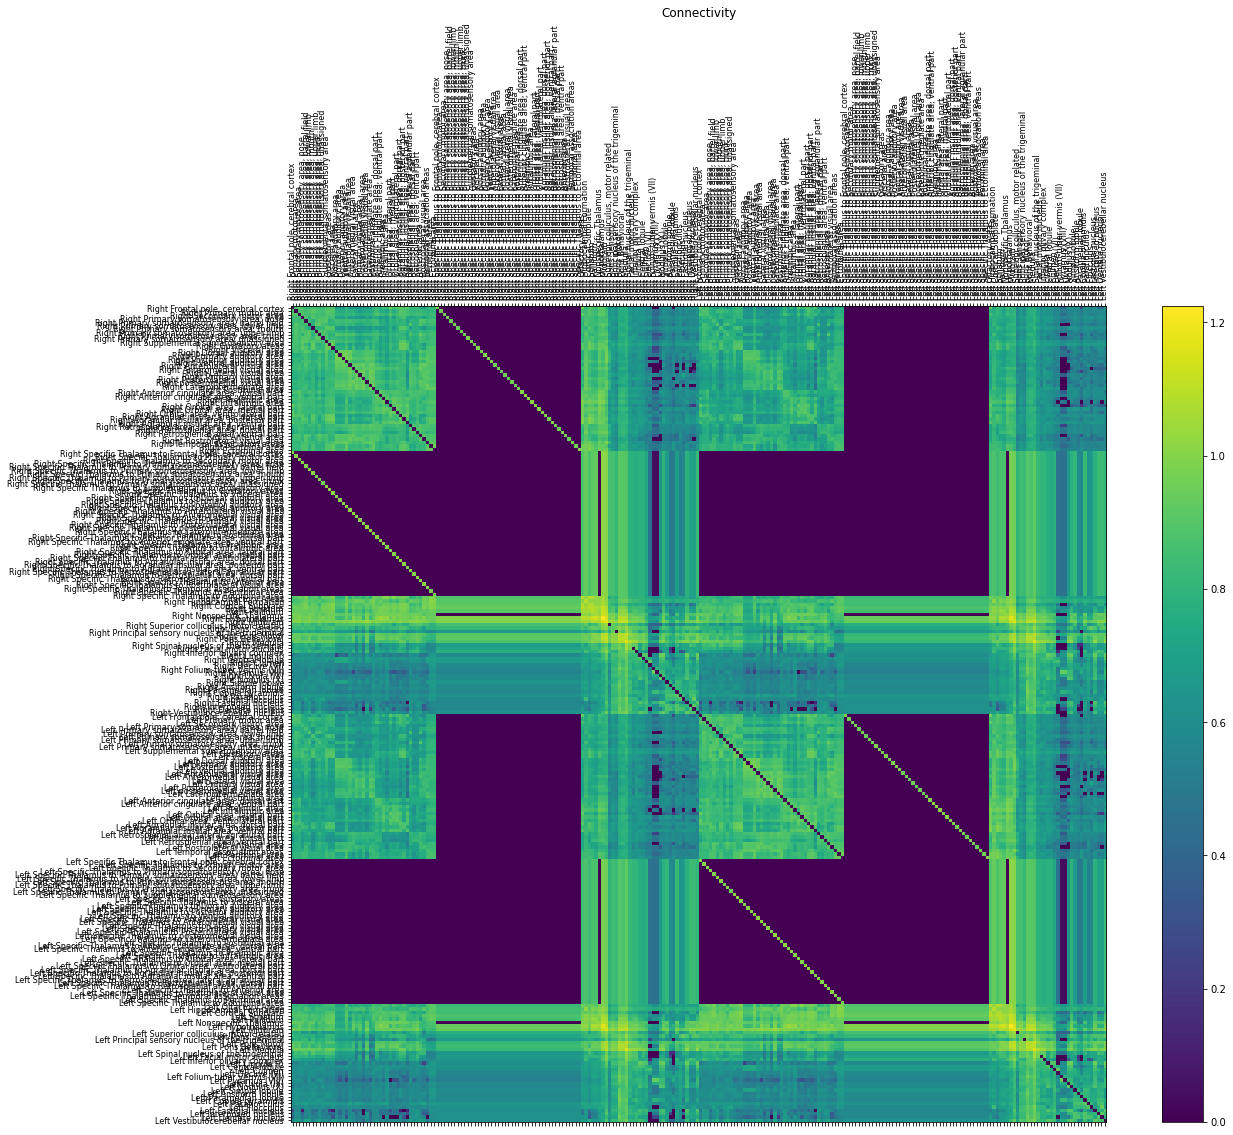

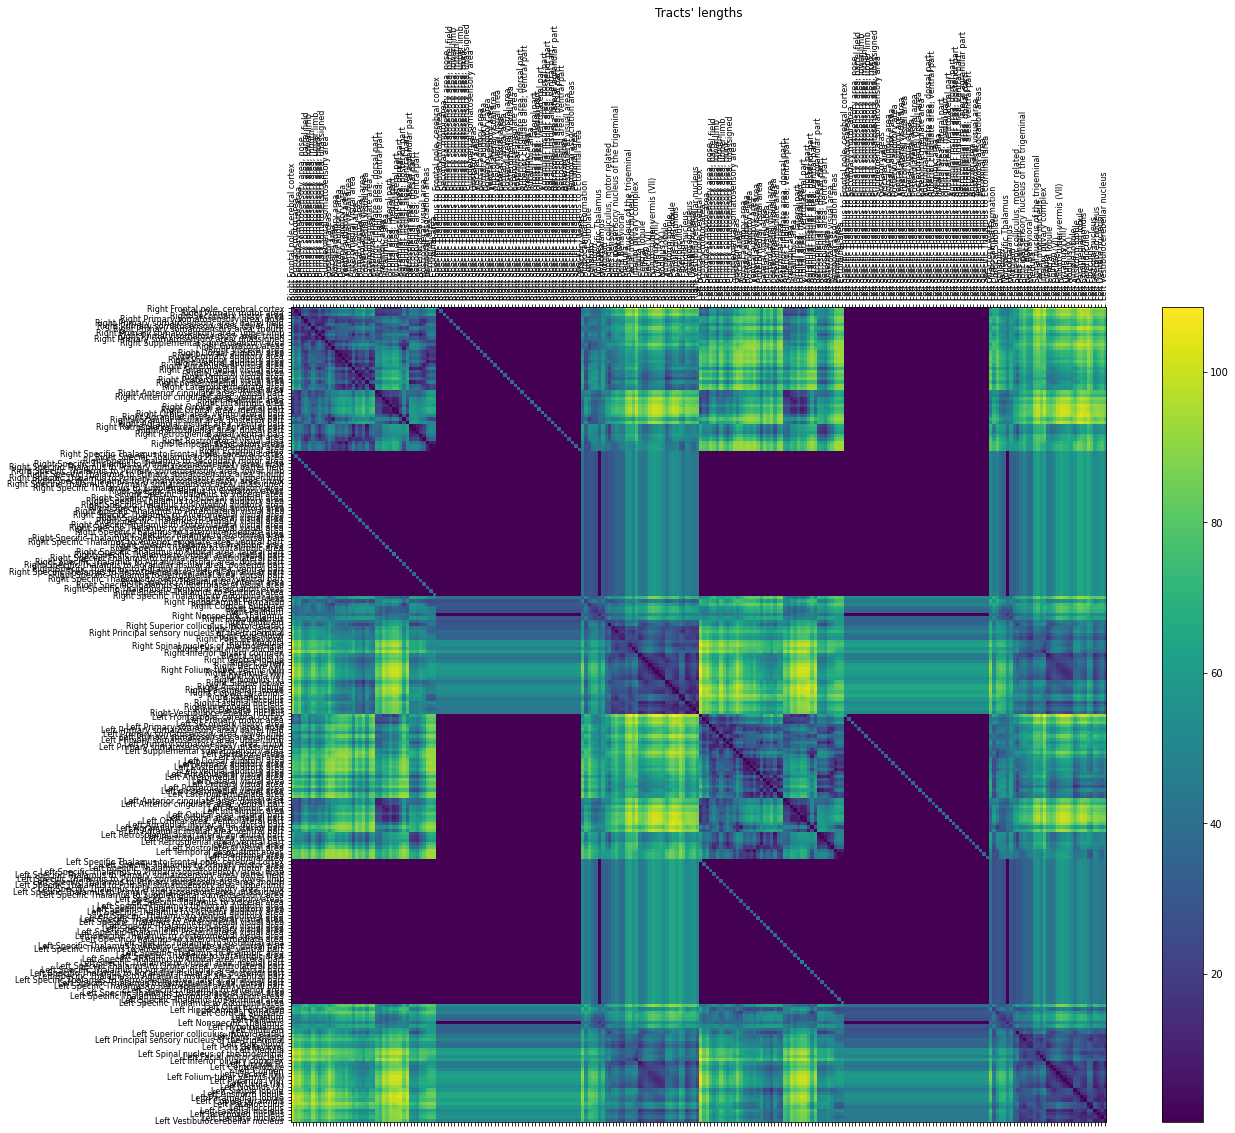

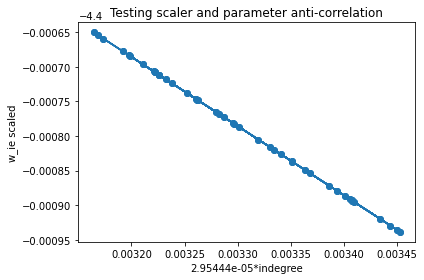

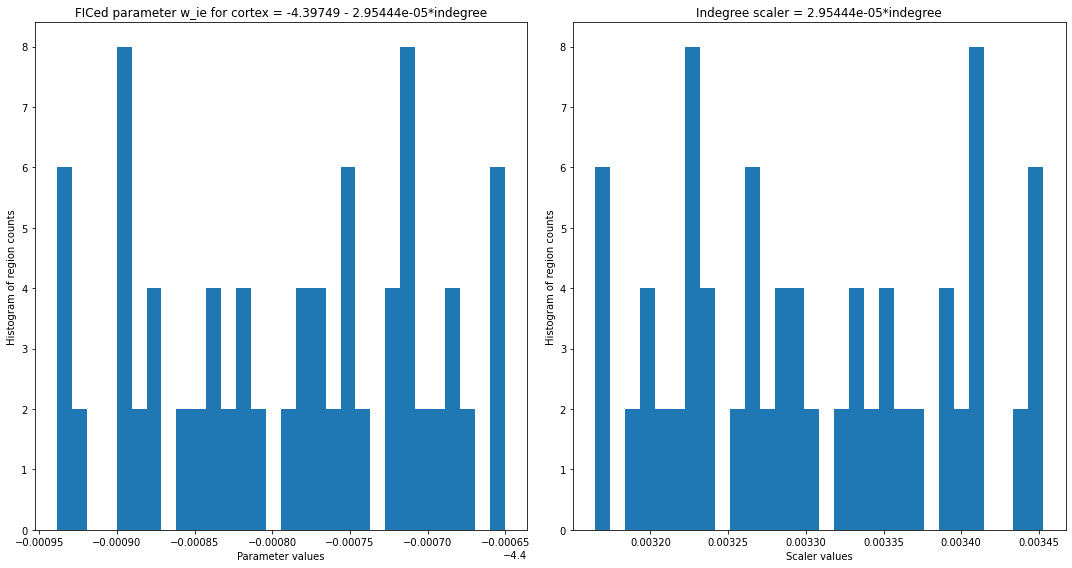

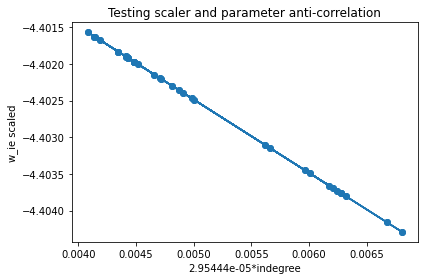

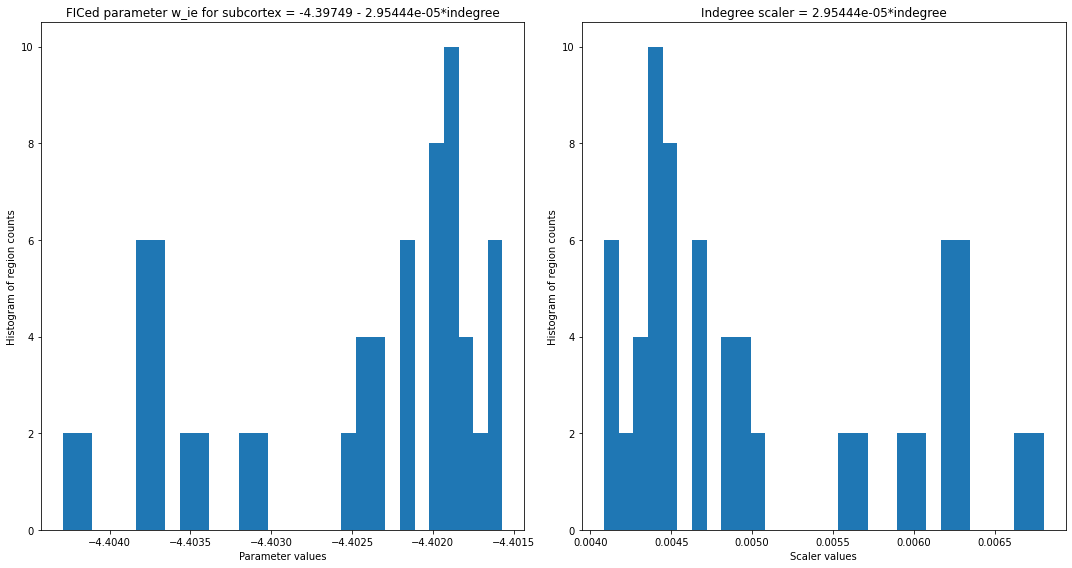

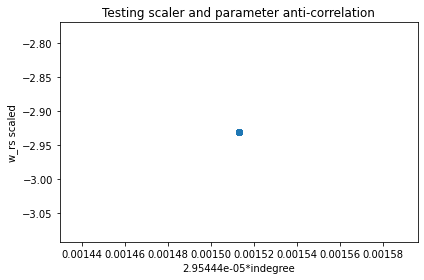

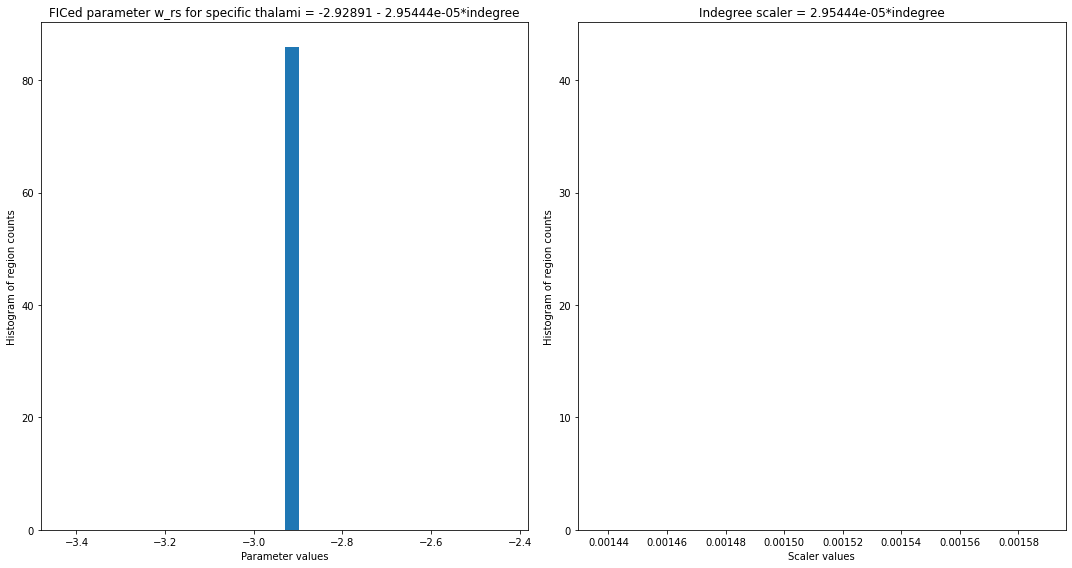

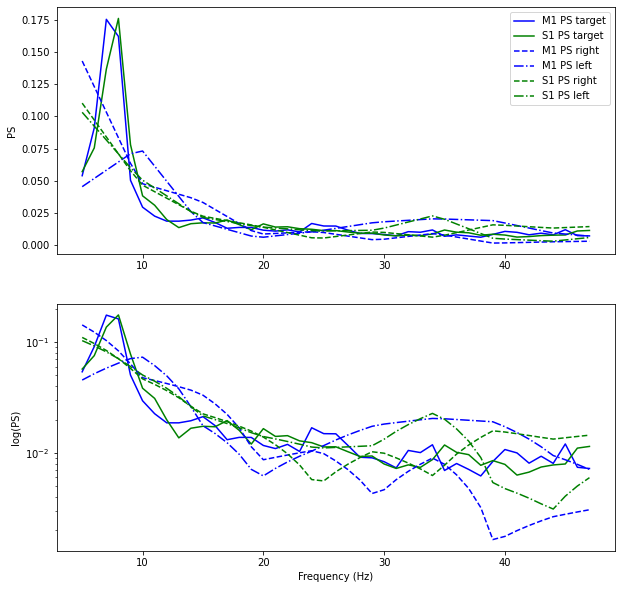

In [2]:
samples_fit_Gs, results, fig = sbi_fit(5, config=None);
# run_workflow(plot_flag=True)

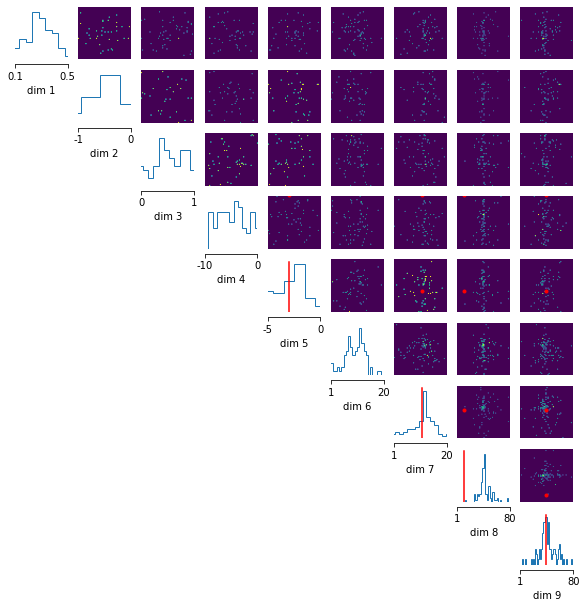

Current step is not 0 upon configuration!
Setting it to 0. Initial condition might be affected!
CoSimulatorSerial (
  title .................... 'CoSimulatorSerial gid: 79bcbead-b529-46a0-ac24-ffd76d785356'
  Type ..................... 'CoSimulatorSerial'
  model .................... WilsonCowanThalamoCortical gid: 60df3fd4-69d8-4cae-ab3c-193772f89b9e
  output_interfaces ........ None
  input_interfaces ......... None
  out_proxy_inds ........... --------------------
  shape .................... (0,)
  dtype .................... int64
  is empty ................. True
  exclusive ................ False
  voi ...................... --------------------
  proxy_inds ............... --------------------
  synchronization_time ..... 0.0
  connectivity ............. Connectivity gid: e54d36e3-bef7-4e00-a440-0c21c0649494
  conduction_speed ......... 3.0
  coupling ................. SigmoidalPreThalamoCortical gid: 5376d1e3-fb77-4750-8331-1baa51696c69
  surface .................. None
  stimu

In [3]:
fig